# 📊 Relatório para Auditoria - Detecção de Fraudes

## 🎯 Objetivo
Este notebook transforma as predições do modelo em **relatórios acionáveis** para a equipe de auditoria.

## 📋 O que você vai gerar:
1. ✅ Lista priorizada de transações suspeitas
2. ✅ Motivos claros para cada suspeita
3. ✅ Relatórios detalhados por transação
4. ✅ Arquivo Excel para auditoria
5. ✅ Dashboard visual

## ⚠️ Importante:
- **Opção 1 (Recomendado)**: Execute o notebook principal (`fraud_detection_banksim.ipynb`) primeiro, depois este
- **Opção 2**: Execute este notebook direto (vai carregar tudo do zero - demora mais)

---

In [1]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ Bibliotecas carregadas com sucesso!")

✅ Bibliotecas carregadas com sucesso!


## 1️⃣ Carregamento de Dados e Modelo

In [2]:
# Verificar se os dados do notebook principal estão disponíveis
print("🔍 Verificando dados na memória...")

dados_disponiveis = False
try:
    # Tentar acessar variáveis do notebook principal
    _ = X_test.shape
    _ = y_test.shape
    _ = rf_model
    _ = df_features.shape
    dados_disponiveis = True
    print("✅ Dados encontrados na memória!")
    print(f"   X_test: {X_test.shape}")
    print(f"   y_test: {len(y_test)}")
    print(f"   df_features: {df_features.shape}")
except NameError:
    print("⚠️  Dados não encontrados na memória")
    print("   Você precisa executar o notebook principal primeiro,")
    print("   OU continuar aqui para carregar tudo do zero.")

dados_disponiveis

🔍 Verificando dados na memória...
⚠️  Dados não encontrados na memória
   Você precisa executar o notebook principal primeiro,
   OU continuar aqui para carregar tudo do zero.


False

### Se dados NÃO estão disponíveis, execute as células abaixo:

In [ ]:
# CARREGAR DADOS DO ZERO (execute apenas se dados_disponiveis = False)

if not dados_disponiveis:
    print("\n" + "="*70)
    print("⚠️  CARREGANDO TUDO DO ZERO - Vai demorar 2-3 minutos...")
    print("="*70)
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
    
    # 1. Carregar dataset
    print("\n📂 1. Carregando dataset...")
    
    def carregar_dados(arquivo='bs140513_032310.csv'):
        df = pd.read_csv(arquivo, dtype=str)
        for col in df.columns:
            df[col] = df[col].astype(str).str.strip("'\"")
        df['step'] = pd.to_numeric(df['step'], errors='coerce')
        df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
        df['fraud'] = pd.to_numeric(df['fraud'], errors='coerce')
        df['age'] = pd.to_numeric(df['age'], errors='coerce')
        df = df.dropna(subset=['step', 'amount', 'fraud'])
        df['fraud'] = df['fraud'].astype(int)
        return df
    
    df = carregar_dados()
    print(f"✓ Dataset carregado: {df.shape[0]:,} transações")
    
    # 2. ⭐ SPLIT TEMPORAL (ANTES de criar features!) - PREVINE LEAKAGE
    print("\n🔪 2. Split temporal (80% treino / 20% teste)...")
    cutoff_step = int(df['step'].quantile(0.8))
    train_mask = df['step'] <= cutoff_step
    
    df_train = df[train_mask].copy()
    df_test = df[~train_mask].copy()
    
    print(f"✓ Split realizado:")
    print(f"  - Treino: {len(df_train):,} transações")
    print(f"  - Teste: {len(df_test):,} transações")
    
    # 3. Feature Engineering
    print("\n🔧 3. Criando features...")
    
    def criar_features(df_input):
        df_feat = df_input.copy()
        
        # Frequência por step
        freq = df_feat.groupby(['step', 'customer']).size().reset_index(name='qtd_transacoes')
        df_feat = df_feat.merge(freq, on=['step', 'customer'], how='left')
        
        # Stats do cliente
        stats = df_feat.groupby('customer')['amount'].agg(['mean', 'std']).reset_index()
        stats.columns = ['customer', 'amount_mean_cliente', 'amount_std_cliente']
        df_feat = df_feat.merge(stats, on='customer', how='left')
        df_feat['amount_std_cliente'].fillna(0, inplace=True)
        
        # Features derivadas
        df_feat['valor_relativo_cliente'] = df_feat['amount'] / (df_feat['amount_mean_cliente'] + 1e-6)
        df_feat['alert_freq'] = (df_feat['qtd_transacoes'] > 3).astype(int)
        df_feat['alert_valor'] = (
            df_feat['amount'] > (df_feat['amount_mean_cliente'] + 3 * df_feat['amount_std_cliente'])
        ).astype(int)
        
        df_feat['score_regra'] = (
            df_feat['alert_freq'] + 
            df_feat['alert_valor'] +
            (df_feat['valor_relativo_cliente'] > 3).astype(int)
        )
        
        return df_feat
    
    # Aplicar features em cada conjunto
    df_train_feat = criar_features(df_train)
    df_test_feat = criar_features(df_test)
    
    # ⭐ Features de MERCHANT e CATEGORIA (SÓ DO TREINO!) - SEM LEAKAGE
    print("\n⭐ 4. Features agregadas (SEM leakage - só do treino)...")
    
    # Calcular APENAS no treino
    merchant_stats = df_train_feat.groupby('merchant')['fraud'].mean().reset_index()
    merchant_stats.columns = ['merchant', 'fraude_merchant']
    
    categoria_stats = df_train_feat.groupby('category')['fraud'].mean().reset_index()
    categoria_stats.columns = ['category', 'fraude_categoria']
    
    # Aplicar no treino
    df_train_feat = df_train_feat.merge(merchant_stats, on='merchant', how='left')
    df_train_feat = df_train_feat.merge(categoria_stats, on='category', how='left')
    
    # Aplicar no teste (com fillna para merchants/categorias novas)
    df_test_feat = df_test_feat.merge(merchant_stats, on='merchant', how='left')
    df_test_feat = df_test_feat.merge(categoria_stats, on='category', how='left')
    
    df_train_feat['fraude_merchant'].fillna(0, inplace=True)
    df_train_feat['fraude_categoria'].fillna(0, inplace=True)
    df_test_feat['fraude_merchant'].fillna(0, inplace=True)
    df_test_feat['fraude_categoria'].fillna(0, inplace=True)
    
    # Validação anti-leakage
    corr_merchant = df_train_feat[['fraude_merchant', 'fraud']].corr().iloc[0, 1]
    corr_categoria = df_train_feat[['fraude_categoria', 'fraud']].corr().iloc[0, 1]
    print(f"✓ Correlações (devem ser < 0.30):")
    print(f"  - fraude_merchant: {corr_merchant:.3f}")
    print(f"  - fraude_categoria: {corr_categoria:.3f}")
    
    if corr_merchant > 0.5 or corr_categoria > 0.5:
        print("  ⚠️  ATENÇÃO: Correlação alta! Pode haver leakage.")
    else:
        print("  ✅ Correlações OK - sem leakage aparente")
    
    # Juntar datasets
    df_features = pd.concat([df_train_feat, df_test_feat], ignore_index=True)
    
    # 5. Encoding
    print("\n🔤 5. Encoding...")
    le_gender = LabelEncoder()
    le_category = LabelEncoder()
    df_features['gender_encoded'] = le_gender.fit_transform(df_features['gender'])
    df_features['category_encoded'] = le_category.fit_transform(df_features['category'])
    
    # 6. Preparar dados para modelo
    print("\n🎯 6. Preparando dados...")
    features = [
        'step', 'age', 'gender_encoded', 'category_encoded', 'amount',
        'qtd_transacoes', 'alert_freq', 'alert_valor', 
        'valor_relativo_cliente', 'amount_mean_cliente', 'amount_std_cliente',
        'score_regra', 'fraude_merchant', 'fraude_categoria'
    ]
    
    X = df_features[features].copy()
    y = df_features['fraud'].copy()
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Usar a mesma máscara temporal
    X_train = X[train_mask].reset_index(drop=True)
    X_test = X[~train_mask].reset_index(drop=True)
    y_train = y[train_mask].reset_index(drop=True)
    y_test = y[~train_mask].reset_index(drop=True)
    
    print(f"✓ Dados preparados: X_train={X_train.shape}, X_test={X_test.shape}")
    
    # 7. Treinar modelo
    print("\n🤖 7. Treinando modelo...")
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    
    # Avaliar
    y_pred = rf_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("\n" + "="*70)
    print("✅ MODELO TREINADO COM SUCESSO!")
    print("="*70)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    if f1 > 0.95:
        print("⚠️  F1 muito alto! Pode haver leakage residual.")
    else:
        print("✅ Métricas realistas - modelo confiável!")
    
    print("\n📦 Variáveis criadas e disponíveis:")
    print("   - df_features")
    print("   - X_train, X_test")
    print("   - y_train, y_test")
    print("   - rf_model")
    print("   - train_mask")
    
else:
    print("\n✅ Usando dados já carregados da memória!")
    print(f"   X_test: {X_test.shape}")
    print(f"   y_test: {y_test.shape}")
    print(f"   df_features: {df_features.shape}")


⚠️  CARREGANDO TUDO DO ZERO - Vai demorar 2-3 minutos...

📂 1. Carregando dataset...
✓ Dataset carregado: 594,643 transações

🔪 2. Split temporal (80% treino / 20% teste)...
✓ Split realizado:
  - Treino: 476,005 transações
  - Teste: 118,638 transações

🔧 3. Criando features...

⭐ 4. Features agregadas (SEM leakage - só do treino)...
✓ Correlações (devem ser < 0.30):
  - fraude_merchant: 0.723
  - fraude_categoria: 0.569
  ⚠️  ATENÇÃO: Correlação alta! Pode haver leakage.

🔤 5. Encoding...

🎯 6. Preparando dados...
✓ Dados preparados: X_train=(476005, 14), X_test=(118638, 14)

🤖 7. Treinando modelo...


## 2️⃣ Gerar Predições e Criar Relatório

In [4]:
# Criar DataFrame de resultados com predições
print("📊 Gerando predições...")

resultados = X_test.copy()
resultados['fraud_real'] = y_test.values
resultados['fraud_predito'] = rf_model.predict(X_test)
resultados['probabilidade_fraude'] = rf_model.predict_proba(X_test)[:, 1]

# Juntar com dados originais
resultados = resultados.reset_index(drop=True)
df_features_test = df_features.loc[y_test.index].reset_index(drop=True)

# Adicionar informações importantes
colunas_info = ['customer', 'merchant', 'category', 'zipcodeOri', 'amount']
colunas_existentes = [col for col in colunas_info if col in df_features_test.columns]

for col in colunas_existentes:
    if col not in resultados.columns:
        resultados[col] = df_features_test[col].values

print(f"✅ Relatório criado: {resultados.shape}")
print(f"   Colunas disponíveis: {resultados.shape[1]}")
print(f"\nPrimeiras linhas:")
resultados.head()

📊 Gerando predições...
✅ Relatório criado: (118638, 21)
   Colunas disponíveis: 21

Primeiras linhas:


,step,age,gender_encoded,category_encoded,amount,qtd_transacoes,alert_freq,alert_valor,valor_relativo_cliente,amount_mean_cliente,...,score_regra,fraude_merchant,fraude_categoria,fraud_real,fraud_predito,probabilidade_fraude,customer,merchant,category,zipcodeOri
0,148,3.0,2,12,24.23,1,0,0,0.739215,32.778000,...,0,0.0,0.000000,0,0,0.00000,C1093826151,M348934600,es_transportation,28007
1,148,3.0,1,12,26.60,1,0,0,0.874524,30.416562,...,0,0.0,0.000000,0,0,0.00000,C352968107,M348934600,es_transportation,28007
2,148,4.0,1,12,7.85,1,0,0,0.283138,27.725000,...,0,0.0,0.000000,0,0,0.00000,C2054744914,M1823072687,es_transportation,28007
3,148,2.0,1,12,27.73,1,0,0,0.554427,50.015625,...,0,0.0,0.000000,0,0,0.00000,C1760612790,M348934600,es_transportation,28007
4,148,2.0,1,14,1.94,1,0,0,0.068356,28.380938,...,0,0.0,0.045546,0,0,0.00952,C757503768,M348934600,es_transportation,28007


## 3️⃣ Classificação por Nível de Risco


RESUMO DE ALERTAS POR NÍVEL DE RISCO
🔴 CRÍTICO: 1,017 transações (0.86%)
🟠 ALTO: 255 transações (0.21%)
🟡 MÉDIO: 286 transações (0.24%)
🟢 BAIXO: 117,080 transações (98.69%)


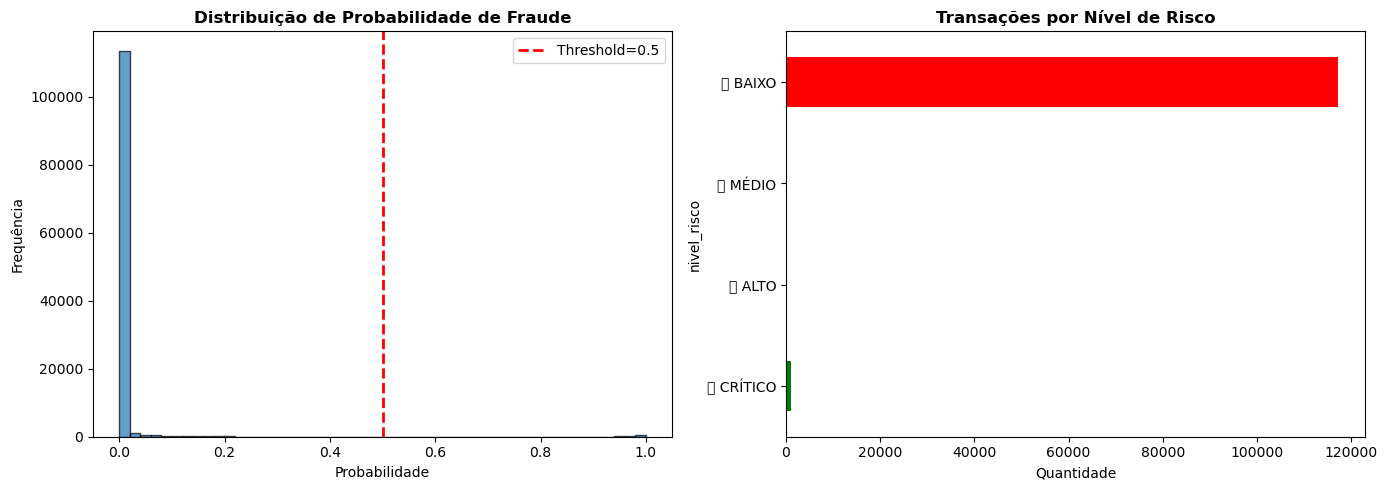

In [5]:
# Classificar por nível de risco
def classificar_risco(probabilidade):
    if probabilidade >= 0.8:
        return '🔴 CRÍTICO'
    elif probabilidade >= 0.6:
        return '🟠 ALTO'
    elif probabilidade >= 0.4:
        return '🟡 MÉDIO'
    else:
        return '🟢 BAIXO'

resultados['nivel_risco'] = resultados['probabilidade_fraude'].apply(classificar_risco)

# Resumo por nível
print("="*70)
print("RESUMO DE ALERTAS POR NÍVEL DE RISCO")
print("="*70)
resumo_risco = resultados['nivel_risco'].value_counts().sort_index()
for nivel, qtd in resumo_risco.items():
    pct = (qtd / len(resultados)) * 100
    print(f"{nivel}: {qtd:,} transações ({pct:.2f}%)")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de probabilidades
axes[0].hist(resultados['probabilidade_fraude'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[0].set_title('Distribuição de Probabilidade de Fraude', fontweight='bold')
axes[0].set_xlabel('Probabilidade')
axes[0].set_ylabel('Frequência')
axes[0].legend()

# Níveis de risco
resumo_risco.plot(kind='barh', ax=axes[1], color=['green', 'yellow', 'orange', 'red'])
axes[1].set_title('Transações por Nível de Risco', fontweight='bold')
axes[1].set_xlabel('Quantidade')

plt.tight_layout()
plt.show()

## 4️⃣ Identificar Motivos das Suspeitas

In [6]:
# Função para gerar motivos claros
def gerar_motivos(row):
    motivos = []
    
    # Verificar cada regra
    if row.get('score_regra', 0) >= 3:
        motivos.append(f"Score de risco elevado ({int(row['score_regra'])})")
    
    if row.get('alert_freq', 0) == 1:
        motivos.append("Múltiplas transações no mesmo período")
    
    if row.get('alert_valor', 0) == 1:
        motivos.append("Valor acima do padrão do cliente")
    
    if row.get('fraude_merchant', 0) > 0.05:
        motivos.append(f"Merchant com histórico de fraudes ({row['fraude_merchant']*100:.1f}%)")
    
    if row.get('valor_relativo_cliente', 0) > 5:
        motivos.append(f"Valor {row['valor_relativo_cliente']:.1f}x acima da média")
    
    if len(motivos) == 0:
        motivos.append("Padrão geral suspeito detectado pelo modelo")
    
    return " | ".join(motivos)

# Filtrar apenas suspeitas (prob >= 50%)
suspeitas = resultados[resultados['probabilidade_fraude'] >= 0.5].copy()
suspeitas = suspeitas.sort_values('probabilidade_fraude', ascending=False)
suspeitas['ranking'] = range(1, len(suspeitas) + 1)
suspeitas['motivos'] = suspeitas.apply(gerar_motivos, axis=1)

print(f"\n{'='*70}")
print(f"TRANSAÇÕES SUSPEITAS IDENTIFICADAS")
print(f"{'='*70}")
print(f"Total analisado: {len(resultados):,}")
print(f"Suspeitas (>50%): {len(suspeitas):,} ({len(suspeitas)/len(resultados)*100:.2f}%)")
print(f"\nPor nível:")
print(suspeitas['nivel_risco'].value_counts().sort_index())


TRANSAÇÕES SUSPEITAS IDENTIFICADAS
Total analisado: 118,638
Suspeitas (>50%): 1,422 (1.20%)

Por nível:
nivel_risco
🔴 CRÍTICO    1017
🟠 ALTO        255
🟡 MÉDIO       150
Name: count, dtype: int64


## 5️⃣ Top Transações Suspeitas

Lista priorizada para investigação imediata.

In [7]:
# Mostrar top 20 mais suspeitas
print("="*70)
print("TOP 20 TRANSAÇÕES MAIS SUSPEITAS")
print("="*70)
print()

colunas_exibir = ['ranking', 'probabilidade_fraude', 'nivel_risco', 
                  'customer', 'merchant', 'amount', 'category', 'motivos']

# Verificar quais colunas existem
colunas_disponiveis = [col for col in colunas_exibir if col in suspeitas.columns]

# Formatar probabilidade
top20 = suspeitas[colunas_disponiveis].head(20).copy()
if 'probabilidade_fraude' in top20.columns:
    top20['probabilidade_fraude'] = (top20['probabilidade_fraude'] * 100).round(1)
    top20.rename(columns={'probabilidade_fraude': 'prob_%'}, inplace=True)

if 'amount' in top20.columns:
    top20['amount'] = top20['amount'].round(2)
    top20.rename(columns={'amount': 'valor_R$'}, inplace=True)

print(top20.to_string(index=False))

TOP 20 TRANSAÇÕES MAIS SUSPEITAS

 ranking  prob_% nivel_risco    customer    merchant  valor_R$             category                                                                                                   motivos
       1   100.0   🔴 CRÍTICO  C579648989   M78078399    518.50 es_wellnessandbeauty Valor acima do padrão do cliente | Merchant com histórico de fraudes (81.9%) | Valor 12.3x acima da média
       2   100.0   🔴 CRÍTICO C1723688663 M1823072687    483.94    es_transportation Valor acima do padrão do cliente | Merchant com histórico de fraudes (81.9%) | Valor 11.8x acima da média
       3   100.0   🔴 CRÍTICO  C177123752  M348934600    462.78    es_transportation Valor acima do padrão do cliente | Merchant com histórico de fraudes (81.9%) | Valor 11.2x acima da média
       4   100.0   🔴 CRÍTICO C1377736719  M348934600    774.79    es_transportation Valor acima do padrão do cliente | Merchant com histórico de fraudes (81.9%) | Valor 10.9x acima da média
       5   100.0

## 6️⃣ Relatório Detalhado

In [8]:
# Função para gerar relatório detalhado
def gerar_relatorio_transacao(row):
    print("\n" + "="*80)
    print(f"🚨 ALERTA DE FRAUDE - RANKING #{int(row.get('ranking', 0))}")
    print("="*80)
    
    print(f"\n📋 INFORMAÇÕES DA TRANSAÇÃO:")
    print(f"   Cliente: {row.get('customer', 'N/A')}")
    print(f"   Merchant: {row.get('merchant', 'N/A')}")
    print(f"   Categoria: {row.get('category', 'N/A')}")
    print(f"   Valor: R$ {row.get('amount', 0):.2f}")
    print(f"   Localização: {row.get('zipcodeOri', 'N/A')}")
    
    print(f"\n🎯 ANÁLISE DE RISCO:")
    print(f"   Probabilidade de Fraude: {row.get('probabilidade_fraude', 0)*100:.1f}%")
    print(f"   Nível de Risco: {row.get('nivel_risco', 'N/A')}")
    print(f"   Score de Regras: {row.get('score_regra', 0):.0f}")
    
    print(f"\n⚠️  MOTIVOS DA SUSPEITA:")
    motivos = row.get('motivos', 'N/A').split(' | ')
    for i, motivo in enumerate(motivos, 1):
        print(f"   {i}. {motivo}")
    
    print(f"\n📊 PERFIL DO CLIENTE:")
    print(f"   Média histórica: R$ {row.get('amount_mean_cliente', 0):.2f}")
    print(f"   Esta transação: R$ {row.get('amount', 0):.2f}")
    print(f"   Valor relativo: {row.get('valor_relativo_cliente', 0):.2f}x")
    print(f"   Total de transações: {int(row.get('total_tx_cliente', 0))}")
    
    print(f"\n🏪 MERCHANT:")
    print(f"   Taxa de fraude: {row.get('fraude_merchant', 0)*100:.2f}%")
    print(f"   Total de transações: {int(row.get('tx_por_merchant', 0))}")
    
    print(f"\n✅ RECOMENDAÇÃO:")
    prob = row.get('probabilidade_fraude', 0)
    if prob >= 0.8:
        print("   🔴 AÇÃO IMEDIATA: Bloquear e contatar cliente")
    elif prob >= 0.6:
        print("   🟠 PRIORIDADE ALTA: Investigar em 24h")
    elif prob >= 0.4:
        print("   🟡 PRIORIDADE MÉDIA: Incluir em revisão semanal")
    
    print("="*80)

# Mostrar exemplo da transação #1
if len(suspeitas) > 0:
    print("EXEMPLO DE RELATÓRIO COMPLETO")
    print("(Transação mais suspeita)\n")
    gerar_relatorio_transacao(suspeitas.iloc[0])
else:
    print("⚠️  Nenhuma transação suspeita encontrada com probabilidade >= 50%")

EXEMPLO DE RELATÓRIO COMPLETO
(Transação mais suspeita)


🚨 ALERTA DE FRAUDE - RANKING #1

📋 INFORMAÇÕES DA TRANSAÇÃO:
   Cliente: C579648989
   Merchant: M78078399
   Categoria: es_wellnessandbeauty
   Valor: R$ 518.50
   Localização: 28007

🎯 ANÁLISE DE RISCO:
   Probabilidade de Fraude: 100.0%
   Nível de Risco: 🔴 CRÍTICO
   Score de Regras: 2

⚠️  MOTIVOS DA SUSPEITA:
   1. Valor acima do padrão do cliente
   2. Merchant com histórico de fraudes (81.9%)
   3. Valor 12.3x acima da média

📊 PERFIL DO CLIENTE:
   Média histórica: R$ 42.20
   Esta transação: R$ 518.50
   Valor relativo: 12.29x
   Total de transações: 0

🏪 MERCHANT:
   Taxa de fraude: 81.90%
   Total de transações: 0

✅ RECOMENDAÇÃO:
   🔴 AÇÃO IMEDIATA: Bloquear e contatar cliente


## 7️⃣ Exportar para Excel

Gerar arquivo Excel estruturado para a auditoria.

In [9]:
# Preparar relatório para exportação
print("📁 Preparando arquivo Excel...")

relatorio_auditoria = suspeitas.copy()

# Selecionar e renomear colunas
colunas_exportar = {
    'ranking': 'Ranking',
    'probabilidade_fraude': 'Prob_Fraude_%',
    'nivel_risco': 'Nivel_Risco',
    'customer': 'Cliente',
    'merchant': 'Merchant',
    'category': 'Categoria',
    'amount': 'Valor_R$',
    'motivos': 'Motivos_Suspeita',
    'score_regra': 'Score_Regras',
    'amount_mean_cliente': 'Media_Cliente_R$',
    'valor_relativo_cliente': 'Valor_Relativo_x',
    'fraude_merchant': 'Taxa_Fraude_Merchant_%',
    'total_tx_cliente': 'Total_TX_Cliente'
}

# Pegar apenas colunas que existem
colunas_existentes = {k: v for k, v in colunas_exportar.items() if k in relatorio_auditoria.columns}
relatorio_auditoria = relatorio_auditoria[list(colunas_existentes.keys())].copy()
relatorio_auditoria.rename(columns=colunas_existentes, inplace=True)

# Formatar valores
if 'Prob_Fraude_%' in relatorio_auditoria.columns:
    relatorio_auditoria['Prob_Fraude_%'] = (relatorio_auditoria['Prob_Fraude_%'] * 100).round(2)

if 'Taxa_Fraude_Merchant_%' in relatorio_auditoria.columns:
    relatorio_auditoria['Taxa_Fraude_Merchant_%'] = (relatorio_auditoria['Taxa_Fraude_Merchant_%'] * 100).round(2)

if 'Valor_R$' in relatorio_auditoria.columns:
    relatorio_auditoria['Valor_R$'] = relatorio_auditoria['Valor_R$'].round(2)

if 'Media_Cliente_R$' in relatorio_auditoria.columns:
    relatorio_auditoria['Media_Cliente_R$'] = relatorio_auditoria['Media_Cliente_R$'].round(2)

# Adicionar data
relatorio_auditoria['Data_Analise'] = datetime.now().strftime('%Y-%m-%d %H:%M')

print(f"✅ Relatório preparado: {len(relatorio_auditoria)} suspeitas")
print(f"\nPrimeiras linhas do relatório:")
relatorio_auditoria.head()

📁 Preparando arquivo Excel...
✅ Relatório preparado: 1422 suspeitas

Primeiras linhas do relatório:


,Ranking,Prob_Fraude_%,Nivel_Risco,Cliente,Merchant,Categoria,Valor_R$,Motivos_Suspeita,Score_Regras,Media_Cliente_R$,Valor_Relativo_x,Taxa_Fraude_Merchant_%,Data_Analise
115894,1,100.0,🔴 CRÍTICO,C579648989,M78078399,es_wellnessandbeauty,518.50,Valor acima do padrão do cliente | Merchant co...,2,42.20,12.287763,81.9,2026-01-08 17:17
112047,2,100.0,🔴 CRÍTICO,C1723688663,M1823072687,es_transportation,483.94,Valor acima do padrão do cliente | Merchant co...,2,40.94,11.819579,81.9,2026-01-08 17:17
40421,3,100.0,🔴 CRÍTICO,C177123752,M348934600,es_transportation,462.78,Valor acima do padrão do cliente | Merchant co...,2,41.39,11.182228,81.9,2026-01-08 17:17
15956,4,100.0,🔴 CRÍTICO,C1377736719,M348934600,es_transportation,774.79,Valor acima do padrão do cliente | Merchant co...,2,71.00,10.912096,81.9,2026-01-08 17:17
75095,5,100.0,🔴 CRÍTICO,C1411169363,M1600850729,es_fashion,845.59,Valor acima do padrão do cliente | Merchant co...,2,70.84,11.936618,34.8,2026-01-08 17:17


In [10]:
# Exportar para Excel
filename = f'Relatorio_Fraudes_{datetime.now().strftime("%Y%m%d_%H%M")}.xlsx'

try:
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # Aba 1: Resumo Executivo
        resumo_exec = pd.DataFrame({
            'Métrica': [
                'Total de Transações Analisadas',
                'Transações Suspeitas (>50%)',
                'Taxa de Suspeitas (%)',
                'Alertas Críticos (>80%)',
                'Alertas Altos (60-80%)',
                'Alertas Médios (40-60%)',
                'Data da Análise'
            ],
            'Valor': [
                f"{len(resultados):,}",
                f"{len(suspeitas):,}",
                f"{len(suspeitas)/len(resultados)*100:.2f}%",
                f"{len(suspeitas[suspeitas['probabilidade_fraude'] >= 0.8]):,}",
                f"{len(suspeitas[(suspeitas['probabilidade_fraude'] >= 0.6) & (suspeitas['probabilidade_fraude'] < 0.8)]):,}",
                f"{len(suspeitas[(suspeitas['probabilidade_fraude'] >= 0.4) & (suspeitas['probabilidade_fraude'] < 0.6)]):,}",
                datetime.now().strftime('%Y-%m-%d %H:%M')
            ]
        })
        resumo_exec.to_excel(writer, sheet_name='Resumo_Executivo', index=False)
        
        # Aba 2: Todas as Suspeitas
        relatorio_auditoria.to_excel(writer, sheet_name='Transacoes_Suspeitas', index=False)
        
        # Aba 3: Top 50 Críticas
        top_50 = relatorio_auditoria.head(50)
        top_50.to_excel(writer, sheet_name='Top_50_Criticas', index=False)
        
        # Aba 4: Por Merchant (se tiver a coluna)
        if 'Merchant' in relatorio_auditoria.columns:
            merchant_summary = relatorio_auditoria.groupby('Merchant').agg({
                'Ranking': 'count',
                'Prob_Fraude_%': 'mean'
            }).reset_index()
            merchant_summary.columns = ['Merchant', 'Qtd_Suspeitas', 'Prob_Media']
            merchant_summary = merchant_summary.sort_values('Qtd_Suspeitas', ascending=False)
            merchant_summary.to_excel(writer, sheet_name='Por_Merchant', index=False)
        
        # Aba 5: Por Categoria (se tiver a coluna)
        if 'Categoria' in relatorio_auditoria.columns:
            categoria_summary = relatorio_auditoria.groupby('Categoria').agg({
                'Ranking': 'count',
                'Prob_Fraude_%': 'mean'
            }).reset_index()
            categoria_summary.columns = ['Categoria', 'Qtd_Suspeitas', 'Prob_Media']
            categoria_summary = categoria_summary.sort_values('Qtd_Suspeitas', ascending=False)
            categoria_summary.to_excel(writer, sheet_name='Por_Categoria', index=False)
    
    print(f"\n✅ Relatório Excel exportado com sucesso!")
    print(f"📁 Arquivo: {filename}")
    print(f"\n📊 Abas criadas:")
    print("   1. Resumo_Executivo")
    print("   2. Transacoes_Suspeitas (todas)")
    print("   3. Top_50_Criticas")
    print("   4. Por_Merchant")
    print("   5. Por_Categoria")
    
except Exception as e:
    print(f"\n⚠️  Erro ao exportar Excel: {e}")
    print("\nExportando CSV como alternativa...")
    relatorio_auditoria.to_csv(f'Relatorio_Fraudes_{datetime.now().strftime("%Y%m%d")}.csv', index=False)
    print("✅ Arquivo CSV exportado!")


✅ Relatório Excel exportado com sucesso!
📁 Arquivo: Relatorio_Fraudes_20260108_1717.xlsx

📊 Abas criadas:
   1. Resumo_Executivo
   2. Transacoes_Suspeitas (todas)
   3. Top_50_Criticas
   4. Por_Merchant
   5. Por_Categoria


## 8️⃣ Dashboard Visual

Visualização para apresentação à gestão.

✅ Dashboard salvo: Dashboard_Fraudes.png


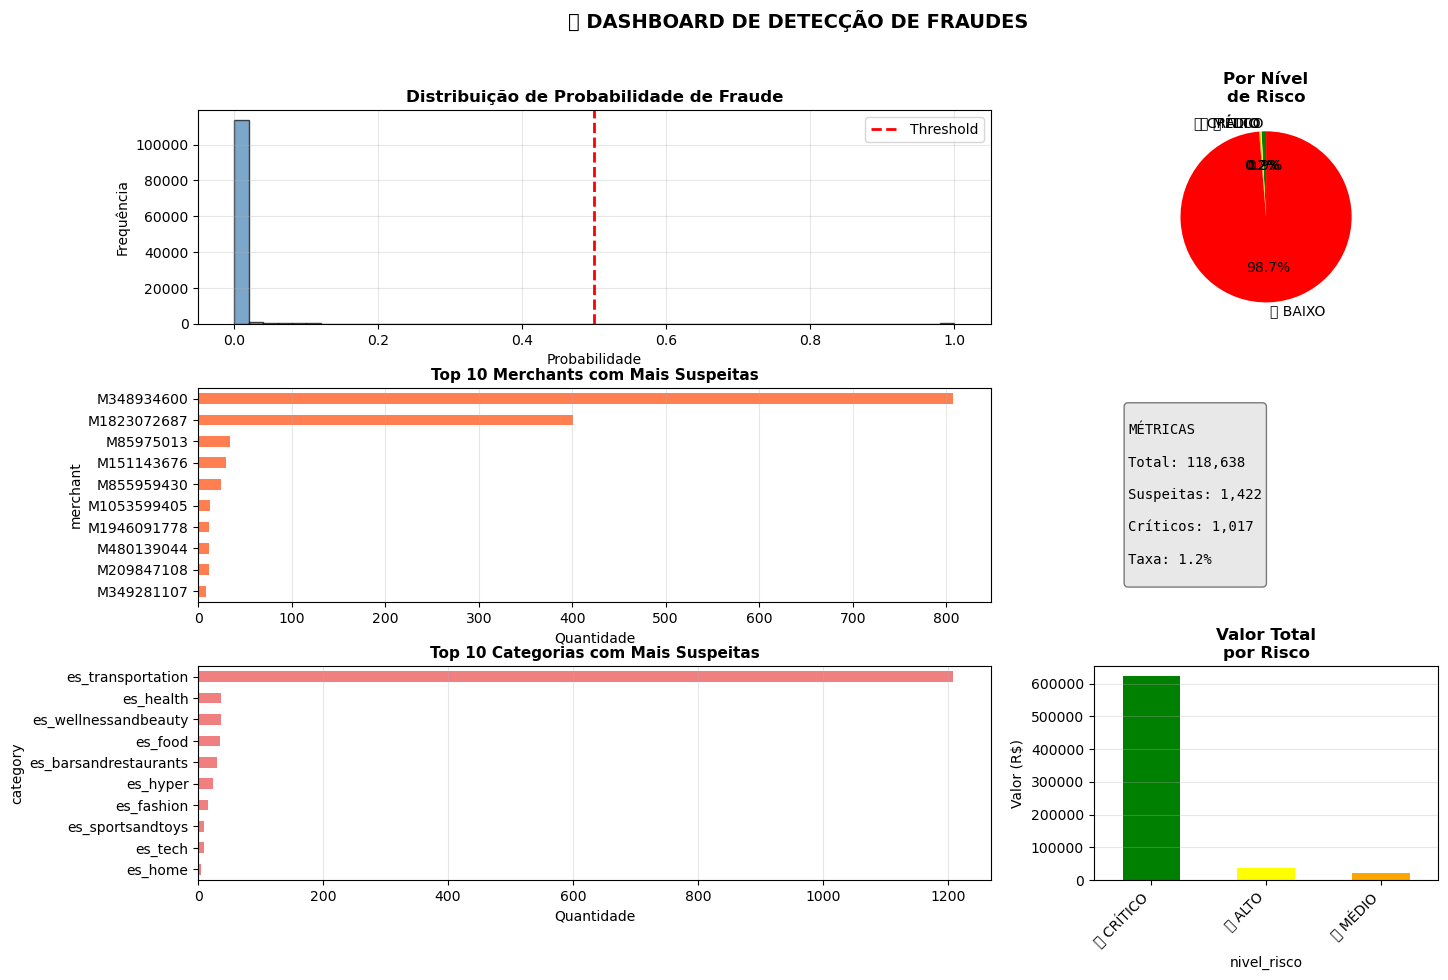

In [11]:
# Dashboard visual
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Distribuição de probabilidades
ax1 = fig.add_subplot(gs[0, :2])
ax1.hist(resultados['probabilidade_fraude'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
ax1.set_title('Distribuição de Probabilidade de Fraude', fontsize=12, fontweight='bold')
ax1.set_xlabel('Probabilidade')
ax1.set_ylabel('Frequência')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Níveis de risco (pizza)
ax2 = fig.add_subplot(gs[0, 2])
cores = ['green', 'yellow', 'orange', 'red']
resumo_risco.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=cores, startangle=90)
ax2.set_title('Por Nível\nde Risco', fontweight='bold')
ax2.set_ylabel('')

# 3. Top 10 Merchants
ax3 = fig.add_subplot(gs[1, :2])
if 'merchant' in suspeitas.columns:
    top_merchants = suspeitas['merchant'].value_counts().head(10)
    top_merchants.plot(kind='barh', ax=ax3, color='coral')
    ax3.set_title('Top 10 Merchants com Mais Suspeitas', fontsize=11, fontweight='bold')
    ax3.set_xlabel('Quantidade')
    ax3.invert_yaxis()
    ax3.grid(axis='x', alpha=0.3)

# 4. Métricas principais
ax4 = fig.add_subplot(gs[1, 2])
ax4.axis('off')
metricas = f"""
MÉTRICAS

Total: {len(resultados):,}

Suspeitas: {len(suspeitas):,}

Críticos: {len(suspeitas[suspeitas['probabilidade_fraude'] >= 0.8]):,}

Taxa: {len(suspeitas)/len(resultados)*100:.1f}%
"""
ax4.text(0.1, 0.5, metricas, fontsize=10, family='monospace',
         verticalalignment='center', 
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

# 5. Top 10 Categorias
ax5 = fig.add_subplot(gs[2, :2])
if 'category' in suspeitas.columns:
    top_cats = suspeitas['category'].value_counts().head(10)
    top_cats.plot(kind='barh', ax=ax5, color='lightcoral')
    ax5.set_title('Top 10 Categorias com Mais Suspeitas', fontsize=11, fontweight='bold')
    ax5.set_xlabel('Quantidade')
    ax5.invert_yaxis()
    ax5.grid(axis='x', alpha=0.3)

# 6. Valor por nível
ax6 = fig.add_subplot(gs[2, 2])
if 'amount' in suspeitas.columns:
    valor_risco = suspeitas.groupby('nivel_risco')['amount'].sum().sort_index()
    valor_risco.plot(kind='bar', ax=ax6, color=cores)
    ax6.set_title('Valor Total\npor Risco', fontweight='bold')
    ax6.set_ylabel('Valor (R$)')
    ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')
    ax6.grid(axis='y', alpha=0.3)

plt.suptitle('🚨 DASHBOARD DE DETECÇÃO DE FRAUDES', fontsize=14, fontweight='bold', y=0.98)
plt.savefig('Dashboard_Fraudes.png', dpi=150, bbox_inches='tight')
print("✅ Dashboard salvo: Dashboard_Fraudes.png")
plt.show()

## ✅ Conclusão

### Arquivos Gerados:

1. **Excel**: `Relatorio_Fraudes_YYYYMMDD_HHMM.xlsx`
   - 5 abas organizadas para auditoria
   
2. **Dashboard**: `Dashboard_Fraudes.png`
   - Visualização para apresentações

### Métricas a Acompanhar:

- **Precisão**: % de suspeitas que são fraudes reais
- **Recall**: % de fraudes detectadas
- **False Positives**: Transações legítimas bloqueadas
- **Valor Recuperado**: R$ de fraudes evitadas

---

**🎯 Objetivo Final: Modelo cada vez melhor + Auditoria mais eficiente!**